In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
Measurement = Base.classes.measurement
Station = Base.classes.station

# reflect the tables
Base.metadata.create_all(engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
measurement = Base.metadata.tables["measurement"]
station = Base.metadata.tables["station"]

In [8]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

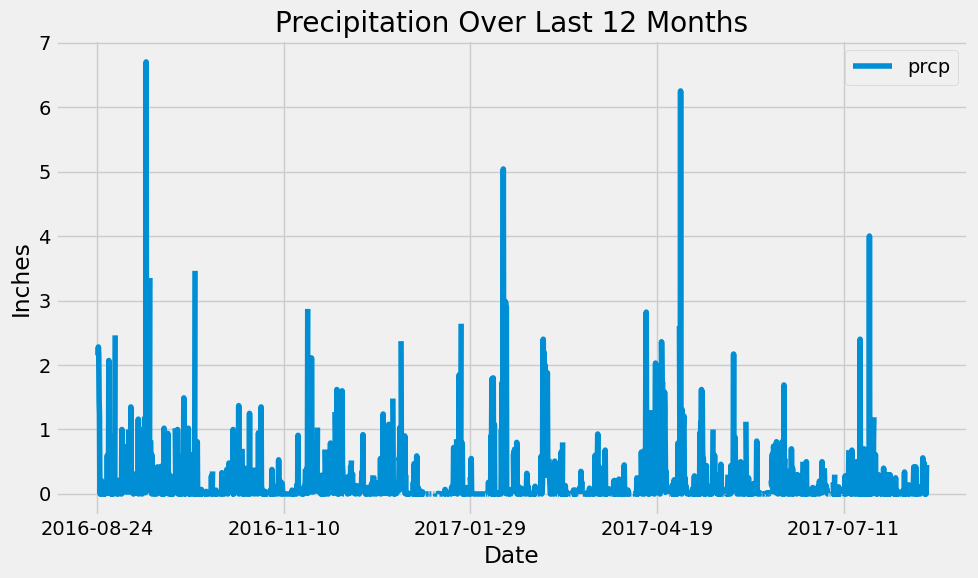

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'prcp'])

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.set_index('date', inplace=True)
precip_df.plot(figsize=(10, 6), title="Precipitation Over Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = precip_df.describe()
precip_stats

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.id))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
# Calculate the lowest, highest, and average temperature for the most active station
temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Unpack the results
lowest_temp, highest_temp, avg_temp = temp_stats[0]

temp_stats[0]


(54.0, 85.0, 71.66378066378067)

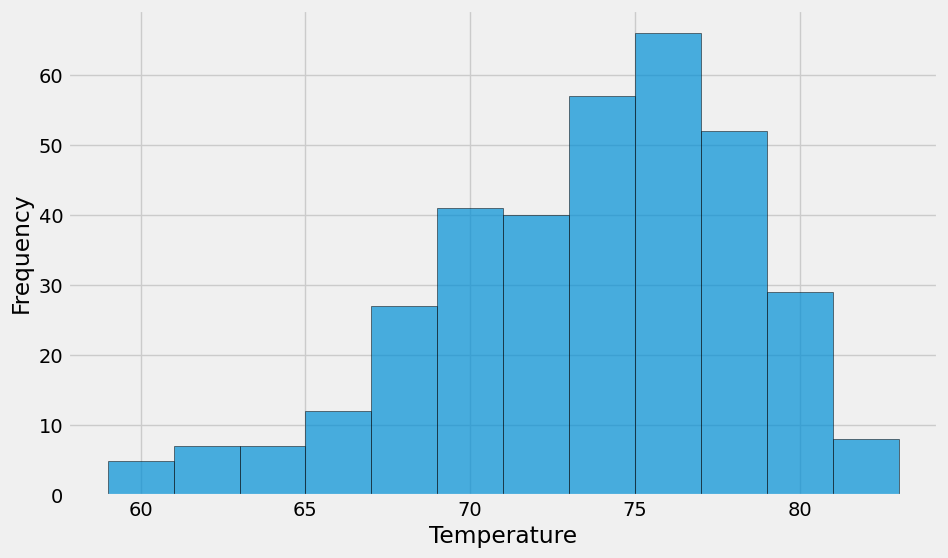

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df['tobs'], bins=12, edgecolor='k', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [29]:
# Close Session
session.close()